In [78]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit, logit
import scipy.ndimage

In [103]:
class NeuralNetwork:

    def __init__(self, input_nodes: int, hidden_nodes : int, output_nodes: int,
                 learning_rate:float):
        self.inodes = input_nodes
        self.hnodes = hidden_nodes
        self.onodes = output_nodes
        self.lr = learning_rate
        self.activation = lambda x: scipy.special.expit(x) # sigmoid activation
        self.activation_prime = lambda x : scipy.special.expit(x) * (1-scipy.special.expit(x)) # derivative of sigmoid
        self.inverse_activation = lambda x: scipy.special.logit(x)
        # I'm setting the weight range the weight matrices to 1/sqrt(output nodes)

        # input to hidden
        # loc at 0 is mean centered at 0
        self.wih = np.random.normal(loc=0.0, scale=pow(self.hnodes, -.5), size=(self.hnodes, self.inodes))

        # hidden to output
        self.who = np.random.normal(loc=0.0, scale=pow(self.onodes, -.5), size=(self.onodes, self.hnodes))



    def train(self, input_list, target_list):
        # turns into (n, 1) column vectors
        inputs = np.array(input_list, ndmin=2).T 
        targets = np.array(target_list, ndmin=2).T

        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activation(hidden_inputs)

        final_inputs = np.dot(self.who, hidden_outputs)
        final_outputs = self.activation(final_inputs)
        
        error_output = targets-final_outputs

        # now we have the error output, time to update our weight matrices

        # FO is final output
        # We need to find how the error responds to changes in weights. dE/dw(i,j).
        # By chain rule this is dE/dFO * dFO/dw(i,j)
        # Change in final output with respect to weights is just the derivative of the activation function since we just did 
        # final_output = activation(final_input)
        # We still need to dot the hidden inputs because the activation function is a function of the inputs & weights. 
        # Essentially: activation_function = sum of (w(i,j) * Ii)
        # Since we're taking the derivative wrt w(i,j) the input Ii (hidden_inputs) is what's left
        self.who += np.dot(self.lr * error_output * self.activation_prime(final_inputs), hidden_outputs.T)

        error_hidden = np.dot(self.who.T, error_output) # multiply the error_output by its respective weight so 
        # larger and smaller error are effected by the weight
        self.wih += np.dot(self.lr * error_hidden * hidden_outputs * (1-hidden_outputs), inputs.T)



    def query(self, input_list):
        # takes a horizontal list of inputs and converts them to 2D column vector
        inputs = np.array(input_list, ndmin=2).T
        #print(f'inputs = {inputs}')
        # calculating signals into the hidden layer
        hidden_inputs = np.dot(self.wih, inputs) # (3,3) * (3,1)
        #print(f'hidden layer inputs = {hidden_inputs}')

        # applying activation function to signals
        hidden_outputs = self.activation(hidden_inputs)
        #print(f'hidden layer outputs = {hidden_outputs}')

        # calculating signals into the final layer
        final_inputs = np.dot(self.who, hidden_outputs)
        #print(f'final layer inputs = {final_inputs}')
        
        # applying activation function to signals
        final_outputs = self.activation(final_inputs)
        #print(f'final layer outputs = {final_outputs}')
        #print(f"i believe the number is {np.where(final_outputs == final_outputs.max())[0]}")
        return final_outputs
    
    def backquery(self, targets_list):
        # transpose the targets list to a vertical array
        final_outputs = np.array(targets_list, ndmin=2).T
        
        # calculate the signal into the final output layer
        final_inputs = self.inverse_activation(final_outputs)

        # calculate the signal out of the hidden layer
        hidden_outputs = np.dot(self.who.T, final_inputs)
        # scale them back to 0.01 to .99
        hidden_outputs -= np.min(hidden_outputs)
        hidden_outputs /= np.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01
        
        # calculate the signal into the hidden layer
        hidden_inputs = self.inverse_activation(hidden_outputs)
        
        # calculate the signal out of the input layer
        inputs = np.dot(self.wih.T, hidden_inputs)
        # scale them back to 0.01 to .99
        inputs -= np.min(inputs)
        inputs /= np.max(inputs)
        inputs *= 0.98
        inputs += 0.01
        
        return inputs

In [104]:
test_file = open("mnist_data/mnist_testing_full.csv")
train_file = open("mnist_data/mnist_training_full.csv")

test_list = test_file.readlines()
train_list = train_file.readlines()

test_file.close()
train_file.close()


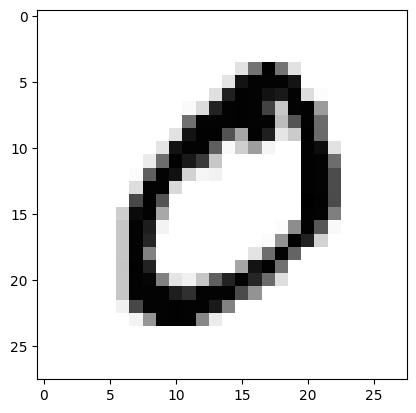

In [105]:
all_values = train_list[1].split(",") # grabbing first image from training
image_array = np.asarray(all_values[1:]).astype(float).reshape(28,28) # turning into 28x28 matrix
plt.imshow(image_array, cmap="Greys", interpolation=None)

In [106]:
input_nodes = 784
hidden_nodes = 100
output_nodes = 10
learning_rate = .1

n = NeuralNetwork(input_nodes=input_nodes, hidden_nodes=hidden_nodes, output_nodes=output_nodes, learning_rate=learning_rate)


In [107]:
epochs = 3
for epoch in range(epochs):
    for pixel_row in train_list:
        values = pixel_row.split(",")
        scaled_input = (np.array(values[1:]).astype(float) / 255.0*.99)+.01 # rescaling to 0-.99 scale, then adding .01 to get to .01-1.00 scale
        target_values = [.01 for i in range(10)] # initialize outputs to .01 because activation function can't reach .01
        target_values[int(values[0])] = .99 # initialize correct val to .99 because activation function can't reach .99
        # its called saturation if weight keeps getting increased for a value the activation function can't output
        n.train(scaled_input, target_values)

In [108]:
guesses = []
for pixel_row in test_list:
    values = pixel_row.split(",")
    scaled_input = (np.array(values[1:]).astype(float) / 255.0*.99)+.01
    model_output = n.query(scaled_input)
    guess = np.argmax(model_output)
    label = int(values[0])
    if label==guess:
        guesses.append(1)
    else:
        guesses.append(0)

print(np.sum(guesses) / len(guesses) * 100)

96.06


In [109]:
my_five = plt.imread("mnist_data/low_res_five.png")
my_five = my_five[:,:,0].flatten() # all rows, all columns, are RGB vals up to but including the 0th (which is none)
my_five = (my_five / 255 * .99) + .01 # scale to .01 to 1
output = n.query(my_five)
guess = np.argmax(output)
guess

np.int64(5)

In [110]:
han_lobster = plt.imread("mnist_data/lobster_inverted.png")
han_lobster = han_lobster[:,:,0].flatten() # all rows, all columns, are RGB vals up to but including the 0th (which is none)
han_lobster = 255 - han_lobster
han_lobster = (han_lobster / 255 * .99) + .01
output = n.query(han_lobster)
guess = np.argmax(output)
guess

np.int64(8)

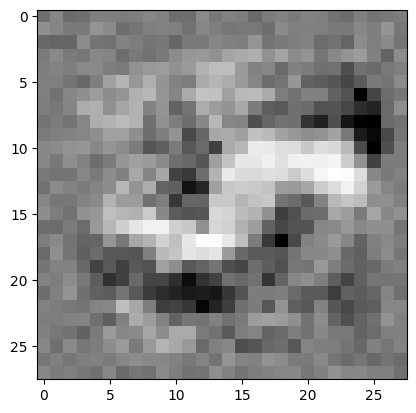

In [111]:
label = 5
targets = np.zeros(10) + .01
targets[label] = .99
image = n.backquery(targets_list=targets)
plt.imshow(image.reshape(28,28), cmap='Greys', interpolation=None)